# Number Plate Detection using YOLOv5 Model

Connect the colab notebook to the drive and import necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install easyocr 

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

import easyocr
reader = easyocr.Reader(['en'])

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Declare the path to useful folders in the project folder

In [4]:
project_directory = "/content/drive/MyDrive/CS445_FinalProject/"
dataset_directory = project_directory + "LicensePlate_Dataset/"
model_directory = project_directory + "Models/"
yolo_directory = project_directory + "Models/yolov5/"

## Preparing the data for the model
We read and process the XML files that has the bounding box information for the images.

In [ ]:
path = glob(dataset_directory+'annotations/*.xml')
# print(path)
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)


    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)


In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/CS445_FinalProject/Lice...,134,262,128,160
1,/content/drive/MyDrive/CS445_FinalProject/Lice...,226,419,125,173
2,/content/drive/MyDrive/CS445_FinalProject/Lice...,141,311,113,164
3,/content/drive/MyDrive/CS445_FinalProject/Lice...,175,214,114,131
4,/content/drive/MyDrive/CS445_FinalProject/Lice...,167,240,202,220


In [ ]:
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'{dataset_directory}images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
    
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
0,/content/drive/MyDrive/CS445_FinalProject/Lice...,134,262,128,160,/content/drive/MyDrive/CS445_FinalProject/Lice...,400,248
1,/content/drive/MyDrive/CS445_FinalProject/Lice...,226,419,125,173,/content/drive/MyDrive/CS445_FinalProject/Lice...,500,268
2,/content/drive/MyDrive/CS445_FinalProject/Lice...,141,311,113,164,/content/drive/MyDrive/CS445_FinalProject/Lice...,471,270
3,/content/drive/MyDrive/CS445_FinalProject/Lice...,175,214,114,131,/content/drive/MyDrive/CS445_FinalProject/Lice...,400,267
4,/content/drive/MyDrive/CS445_FinalProject/Lice...,167,240,202,220,/content/drive/MyDrive/CS445_FinalProject/Lice...,400,300


In [ ]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,/content/drive/MyDrive/CS445_FinalProject/Lice...,134,262,128,160,/content/drive/MyDrive/CS445_FinalProject/Lice...,400,248,0.49500,0.580645,0.320000,0.129032
1,/content/drive/MyDrive/CS445_FinalProject/Lice...,226,419,125,173,/content/drive/MyDrive/CS445_FinalProject/Lice...,500,268,0.64500,0.555970,0.386000,0.179104
2,/content/drive/MyDrive/CS445_FinalProject/Lice...,141,311,113,164,/content/drive/MyDrive/CS445_FinalProject/Lice...,471,270,0.47983,0.512963,0.360934,0.188889
3,/content/drive/MyDrive/CS445_FinalProject/Lice...,175,214,114,131,/content/drive/MyDrive/CS445_FinalProject/Lice...,400,267,0.48625,0.458801,0.097500,0.063670
4,/content/drive/MyDrive/CS445_FinalProject/Lice...,167,240,202,220,/content/drive/MyDrive/CS445_FinalProject/Lice...,400,300,0.50875,0.703333,0.182500,0.060000


In [ ]:
df_train = df.iloc[:200]
df_test = df.iloc[200:]

## Training the Model using Transfer Learning with YOLOv5
Use the **YOLOv5** pre-trained model from pytorch and train it further.

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-24-gf8539a6 Python-3.8.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.0/78.2 GB disk)


In [ ]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images


detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-24-gf8539a6 Python-3.8.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

100% 14.1M/14.1M [00:00<00:00, 330MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 14.3ms
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, 12.2ms
Speed: 0.5ms pre-process, 13.2ms inference, 1.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


Model Preparation

In [ ]:
import yaml

yaml_file = '/content/yolov5/data/plates.yaml'
# path = "data_images",

yaml_data = dict(
    train = "data_images/train",
    val = "data_images/test",
    nc = 1,
    names = ["license_plate"]
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

In [ ]:
!mkdir '/content/yolov5/data_images'
!mkdir '/content/yolov5/data_images/train'
!mkdir '/content/yolov5/data_images/test'


In [ ]:
train_folder = '/content/yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()


In [ ]:
test_folder = '/content/yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

Model Training

In [ ]:
!python /content/yolov5/train.py --data /content/yolov5/data/plates.yaml --cfg /content/yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100


train: weights=yolov5s.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=/content/yolov5/data/plates.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-24-gf8539a6 Python-3.8.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor

Saving the model from a temporary location in drive into our project folder paths

In [ ]:
!python {yolo_directory}export.py --weight {yolo_directory}runs/train/Model2/weights/best.pt --include torchscript onnx


export: data=drive/.shortcut-targets-by-id/1To5km_xGhXdvUPEj_sAKAwFweXS9QhXl/yolov5/data/coco128.yaml, weights=['/content/drive/MyDrive/CS445_FinalProject/Models/yolov5/runs/train/Model2/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-24-gf8539a6 Python-3.8.15 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients

PyTorch: starting from /content/drive/MyDrive/CS445_FinalProject/Models/yolov5/runs/train/Model2/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 1.12.1+cu113...
TorchScript: export success ✅ 3.5s, saved as /content/drive/MyDrive/CS445_FinalProject/Models/yolov5/runs/train/Model2/weights/

## License Plate Detection
Load the trained model from disk to detect license plates

In [89]:
# It is one of the method we used but didn't work. kept getting errors.

# LOAD YOLO MODEL
# net = cv2.dnn.readNetFromONNX(yolo_directory + 'runs/train/Model2/weights/best.onnx')
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [5]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', yolo_directory+'runs/train/Model2/weights/best.torchscript', force_reload=True)


/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirements "gitpython" "ipython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 2 packages updated per /root/.cache/torch/hu

### License Plate Detection on Images

In [6]:
from google.colab.patches import cv2_imshow

# function to detect number plates from the input image
def detect_licence_plates_on_image(path):
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    h,w,d = image.shape
    image1 = load_img(path,target_size=(500,500))
    result = model(image1)


    image1 = np.array(image1,dtype=np.uint8) # 8 bit array (0,255)
    labels, coordinates = result.xyxyn[0][:, -1], result.xyxyn[0][:, :-1]
    width, height = 500,500 #image.shape[1], image.shape[0]
    print(labels)
    print(coordinates)


    # Denormalize the values
    denorm = np.array([w,h,w,h])

    coords_list = []
    for i in range(len(labels)):
        coords = coordinates[i][0:4]
        coords = coords * denorm
        coords = np.array(coords).astype(np.int32)
        coords_list.append(coords)
        print(coords)

    for i in range(len(labels)):
        row = coords_list[i]
        if coordinates[i][4] >= 0.6:
            x1, y1, x2, y2 = row[0], row[1], row[2], row[3] #int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height)
            plate_crop = image[int(y1):int(y2), int(x1):int(x2)]
            print(plate_crop.shape)
            plt.imshow(plate_crop)
            plt.show()
            ocr_result = reader.readtext(plate_crop, allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
            text = ""
            for j in range(len(ocr_result)):
                text = text + ocr_result[j][1]
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 6) ## BBox
            cv2.putText(image, f"{text}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)

            print(f'Detection: {i+1}. YOLOv5 prob: {row[3]:.2f}, easyOCR results: {ocr_result}')
    
    return image

tensor([0.])
tensor([[0.11925, 0.52868, 0.45422, 0.74760, 0.87407]])
[122 360 465 509]
(149, 343, 3)
Detection: 1. YOLOv5 prob: 509.00, easyOCR results: [([[114, 0], [203, 0], [203, 49], [114, 49]], 'AF', 0.9993566468421778), ([[13, 30], [318, 30], [318, 142], [13, 142]], 'L21405', 0.9974738550610821)]



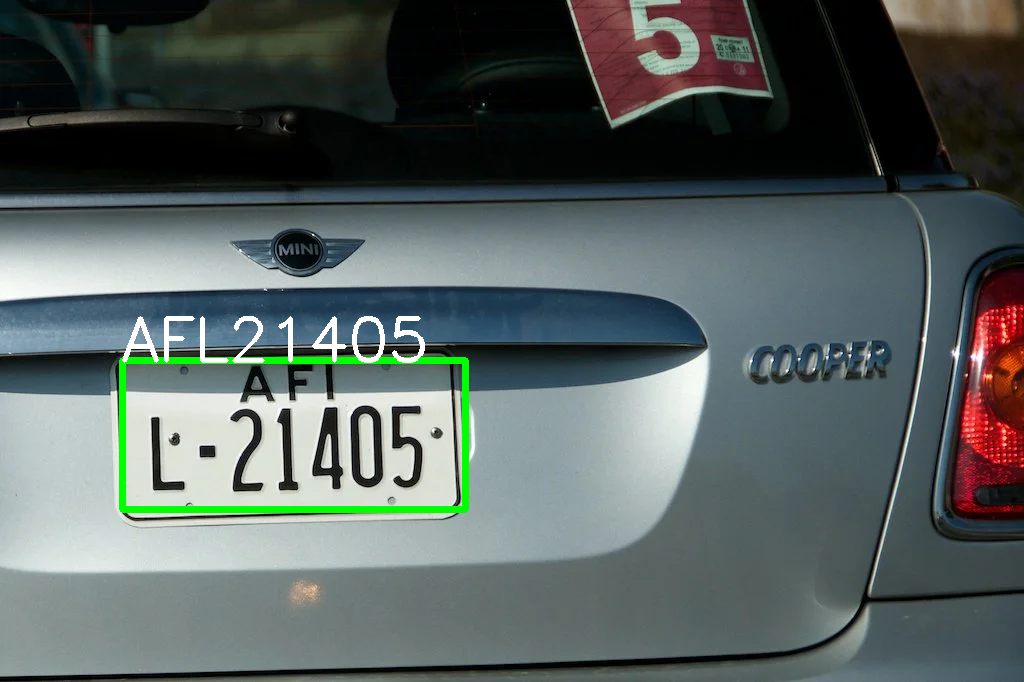

In [113]:
# Read image
path = dataset_directory + "test_images/car1_test.png"
        
image =  detect_licence_plates_on_image(path)    
# cv2_imshow(image)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='License Plate Recognition')

In [115]:
# Read image
path = dataset_directory + "test_images/car3_test.png"

image =  detect_licence_plates_on_image(path)    
# cv2_imshow(image)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='License Plate Recognition')

Output hidden; open in https://colab.research.google.com to view.

tensor([0.])
tensor([[0.10500, 0.69048, 0.31704, 0.82220, 0.82849]])
[ 37 196 112 234]
(38, 75, 3)
Detection: 1. YOLOv5 prob: 234.00, easyOCR results: [([[5, 9], [33, 9], [33, 27], [5, 27]], 'GA03', 0.5811460018157959), ([[38, 14], [70, 14], [70, 38], [38, 38]], 'Q373', 0.21149671077728271)]



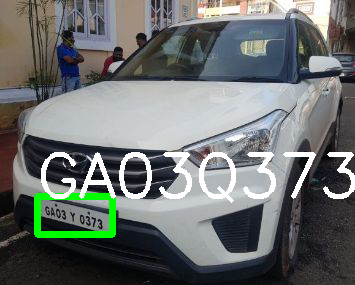

In [9]:
# Read image
path = dataset_directory + "test_images/car7_test.png"
        
image =  detect_licence_plates_on_image(path)    
# cv2_imshow(image)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='License Plate Recognition')

#License Plate Detection and Recognition on a Traffic video stream 

In [109]:
# The code in this cell is referenced from a notebook that was also rendering object detection on a video. 
# We have taken some ideas and soome part of code from there and made updates according to our needs and object.

def get_plates_xy(frame: np.ndarray, labels: list, row: list, width: int, height: int, reader: easyocr.Reader) -> tuple:
    '''Get the results from easyOCR for each frame and return them with bounding box coordinates'''
    
    x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height) ## BBOx coordniates
    cropped_plate = frame[int(y1):int(y2), int(x1):int(x2)]
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) ## BBox
    ocr_result = reader.readtext(np.asarray(cropped_plate), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    
    return ocr_result, x1, y1


def detect_text(i: int, row: list, x1: int, y1: int, ocr_result: list, detections: list, yolo_detection_prob: float=0.3) -> list:
    '''Checks the detection's probability, discards those with low prob and rewrites output from ocr_reader to detections list'''
    
    if row[4] >= yolo_detection_prob: #discard predictions below the value             
        if(len(ocr_result))>0:
            for item in ocr_result:     
                detections[i][0]=item[1]
                detections[i][1]=[x1, y1]
                detections[i][2]=item[2]
    # print("detections",detections)               
    return detections

def is_adjacent(cordinate1: list, coordinate2: list) -> bool:
    '''Checks if [x, y] from list cordinate1 is similar to coordinate2'''
    
    max_pixel_diff=50
    
    if (abs(cordinate1[0] - coordinate2[0]) <= max_pixel_diff) and (abs(cordinate1[1] - coordinate2[1]) <= max_pixel_diff):
        return True
    else:
        return False
    

def sort_detections(detections: list, plates_data: list) -> list:
    '''Looks at detections from last frame and rewrites indexes for similar coordinates'''
    
    for m in range(0, len(detections)):
        for n in range(0, len(plates_data)):
            if not detections[m][1]==[0, 0] and not plates_data[n][1]==[0,0]:
                if is_adjacent(detections[m][1], plates_data[n][1]):
                    if m!=n:
                        temp=detections[m]
                        detections[m] = detections[n]
                        detections[n] = temp
                        
    return detections

def delete_old_labels(detections: list, number_empty_labels: list, plates_data: list, frames_to_reset: int=3) -> tuple:
    '''If earlier detected plate isn't spotted for the next FRAMES_TO_RESET frames, delete it from plates_data'''
    
    for m in range(0, len(detections)):
        if detections[m][0] == 'None' and not number_empty_labels[m] == frames_to_reset:
            number_empty_labels[m]+=1
        elif number_empty_labels[m] == frames_to_reset:
            number_empty_labels[m] = 0
            plates_data[m] = ['None', [0,0], 0]
        else:
            number_empty_labels[m] = 0
            
    return plates_data, number_empty_labels


def overwrite_plates_data(detections: list, plates_data: list, plate_length=None) -> list:
    '''Checks coordinates from detections, if there is similar record in plate_data tries to overwrite it (only if probability is higher)'''
    
    if (detections[i][2]>plates_data[i][2] or detections[i][2] == 0):
        if plate_length:
            if len(detections[i][0]) == plate_length:
                plates_data[i][0] = detections[i][0]
                plates_data[i][2] = detections[i][2]       
        else:
            plates_data[i][0] = detections[i][0]
            plates_data[i][2] = detections[i][2]
    plates_data[i][1] = detections[i][1]
        
    return plates_data

In [ ]:
from google.colab.patches import cv2_imshow
from PIL import Image
from matplotlib import cm

In [97]:
video_path = dataset_directory + "test_images/traffic_test.mp4"

cap = cv2.VideoCapture(video_path)

plates_data = [['None', [0,0], 0] for n in range(5)]
count_empty_labels=[0]*5

assert cap.isOpened()

frame_array = []
while(cap.isOpened()):
    ret, frame = cap.read()

    assert not isinstance(frame,type(None)), 'frame not found'
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)   

    PIL_image = Image.fromarray(frame.astype('uint8'), 'RGB')
    im1 = PIL_image.resize((800,800))

    results = model(im1)   
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
    
    labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
    width, height = frame.shape[1], frame.shape[0]
    
    detections=[['None', [0,0], 0] for n in range(5)]
    i=0 
    
    
    # Read all detected plates per each frame and save them to >>detections<<
    while i < len(labels):    
        row = coordinates[i]
        # 3. Crop detections and pass them to the easyOCR
        ocr_result, x1, y1 = get_plates_xy(frame, labels, row, width, height, reader)  
        
        # 4. Get reading for the each frame
        detections = detect_text(i, row, x1, y1, ocr_result, detections, 0.3)
        i+=1    
    

    # 5. Do some tracking and data managing for better results
    # If we get multiple detections in one frame easyOCR mixes them every few frames, so here we make sure that they are saved according to the 
    # detections' coordinates. Then we delete data about plates that dissapeared for more than >>frames_to_reset<< frames. And finally we overwrite 
    # the predictions (regarding to the probability of easyOCR detections - if new predcition has less p% than the previous one, we skip it.)
    
    # Sort detections 
    detections=sort_detections(detections, plates_data)
    
    # Delete data about plates that dissapeared from frame
    plates_data, count_empty_labels=delete_old_labels(detections, count_empty_labels, plates_data, 3)
            
    # Overwrite data and print text predictions over the boxes
    i=0
    while i < len(labels):
        plates_data=overwrite_plates_data(detections, plates_data, 7)
        cv2.putText(frame, f"{plates_data[i][0]}", (plates_data[i][1]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        i+=1
    
    # cv2_imshow(frame)

    frame_array.append(frame)


    if 0xFF == ord('q'):
        break
        
cap.release()


In [95]:
print(len(frame_array))
print(frame_array[0].shape)


3600
(798, 800, 3)


In [96]:
import numpy as np
import cv2
fourcc = cv2.VideoWriter_fourcc(*'MP42')

hieght, width = frame_array[0].shape[0], frame_array[0].shape[1] 

out = cv2.VideoWriter(dataset_directory + "test_images/traffic_test_YOLO_results.avi",cv2.VideoWriter_fourcc(*'DIVX'), 60, (width, hieght))
 
for i in range(len(frame_array)):
    out.write(frame_array[i])
out.release()